In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib import rc

pd.options.mode.chained_assignment = None 

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (14,6)
plt.rcParams['axes.grid'] = True   

security_data = pd.read_excel("/Users/hyunwoo/Downloads/(한국투자증권)_샘플_및_명세.xlsx")
demand_data = pd.read_excel("/Users/hyunwoo/Downloads/(신한은행)_샘플_및_명세/(신한은행) MZ세대 트렌드 지표_샘플.xlsx")
    
def preprocessing(security_data,demand_data):
    security_columns = security_data.columns[5:]
    
    # 데이터 그룹화
    security_data["연령대"] = security_data['aha'].apply(lambda x : x.split(".")[1])
    security_data['기준년월'] = pd.to_datetime(security_data['기준년월'],format ="%Y%m")
    security_data['성별'] = security_data['성별'].apply(lambda x : 1 if (x == "남자") else 0)
    security_data['연령대'] = security_data['연령대'].str.replace("대","")
    security_data['연령대'] = security_data['연령대'].str.replace("이상","")
    
    local_encoder = LabelEncoder()
    
    demand_data['시군구'] = demand_data["주소"].apply(lambda x: x.split("_")[0])
    demand_data.fillna(0,inplace=True)
    
    age_grouping = {1:"20",2:"30",3:"40",4:"50",5:"60"}
    demand_data['나이대'] = demand_data['나이대'].apply(lambda x: age_grouping[x])
    demand_data
 #전체 데이터 주어질경우 공통되지 않은 "구" 데이터는 제거 할 필요가 있음 
#     demand_data['시군구코드'] = small_local_encoder.transform(demand_data['시군구'])
#     demand_data['그룹코드'] = demand_data['나이대'] + "_" + demand_data['그룹코드'].astype("str")


    local_encoder.fit(security_data['시군구'])
    security_data["시군구코드"] = local_encoder.transform(security_data['시군구'])
    security_data['그룹코드'] = security_data['연령대']+"_"+ security_data['시군구코드'].astype("str")
    
    security_data.drop(columns = {"aha","시도","시군구","시군구코드","연령대"},inplace = True)
    security_data = security_data[security_data.columns[-1:].to_list()+security_data.columns[:-1].to_list()]
    
    # 각각 상품 비율화
    security_only_data = security_data[security_data.columns[3:]]
    security_only_data['총합'] = security_only_data.sum(axis=1)
    security_data['총합'] = security_only_data['총합']
    
    for col in security_columns:
        security_data[col] = security_data[col]/security_data['총합']
        
    security_data.drop(columns = {"총합"},inplace = True)
    
    return security_data,demand_data,local_encoder.classes_

In [2]:
security,demand,grouping = preprocessing(security_data,demand_data)

In [3]:
grouping

array(['강릉시', '거제시', '광산구', '구로구', '서귀포시'], dtype=object)

In [4]:
# 직접 투자 vs 간접 투자
direct_investment = ["국내주식","해외주식","채권","파생결합증권","장내파생상품",'단기금융상품']
indirect_investment = ['펀드','랩','신탁','연금']

In [5]:
# 직접 투자 
security.groupby('그룹코드').mean()[direct_investment].sum(axis=1)

그룹코드
20_0    0.775151
20_4    0.880391
30_0    0.836078
30_1    0.954422
40_1    0.932115
40_2    0.796776
50_2    0.735233
50_3    0.761483
60_3    0.691044
60_4    0.690574
dtype: float64

In [6]:
# 간접 투자
security.groupby('그룹코드').mean()[indirect_investment].sum(axis=1)

그룹코드
20_0    0.114299
20_4    0.083652
30_0    0.081604
30_1    0.031721
40_1    0.045911
40_2    0.136097
50_2    0.210161
50_3    0.140086
60_3    0.137307
60_4    0.135854
dtype: float64

In [7]:
security.groupby('그룹코드').mean()["현물"]

그룹코드
20_0    0.000095
20_4    0.001111
30_0    0.000288
30_1    0.001262
40_1    0.001325
40_2    0.000505
50_2    0.000613
50_3    0.000715
60_3    0.001399
60_4    0.000168
Name: 현물, dtype: float64

In [8]:
demand

,기준년월,성별,나이대,신용카드보유유무,지출비율(50이상_50미만),주소,간편결제,구독서비스,통합적쇼핑플랫폼,택시,...,리셀플랫폼,슈퍼카/외제차,공과금,편의점,다이소,인앱결제,게임(PC방),비디오스트리밍,음악스트리밍,시군구
0,202104,1,20,0,0,강남구_도곡동,7.016,0.000,0.000,10.427,...,0.0,0.000,15.341,12.227,7.761,11.162,12.122,0.000,0.000,강남구
1,202104,1,20,0,0,금천구_독산동,5.725,0.000,0.000,0.000,...,0.0,0.000,0.000,12.840,4.752,8.585,12.028,0.000,0.000,금천구
2,202104,1,20,0,0,성동구_금호동1가,3.177,0.000,0.000,0.000,...,0.0,0.000,0.000,6.471,0.000,0.000,0.000,0.000,0.000,성동구
3,202104,1,20,0,0,영등포구_당산동4가,3.025,0.000,0.000,0.000,...,0.0,0.000,0.000,9.904,0.000,0.000,0.000,0.000,0.000,영등포구
4,202104,1,20,0,1,강동구_고덕동,13.102,11.402,14.002,12.912,...,0.0,0.000,0.000,18.071,7.288,12.167,18.517,0.000,12.157,강동구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,202104,1,50,0,1,영등포구_양평동5가,20.386,0.000,0.000,0.000,...,0.0,0.000,0.000,30.608,0.000,0.000,0.000,0.000,0.000,영등포구
96,202104,1,50,0,1,용산구_원효로4가,13.601,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,용산구
97,202104,1,50,1,0,강남구_일원동,13.003,31.608,0.000,13.452,...,0.0,63.401,17.504,18.641,14.744,10.128,5.996,40.161,0.000,강남구
98,202104,1,50,1,0,강서구_등촌동,13.342,27.291,16.458,13.459,...,0.0,52.065,19.642,21.855,14.921,16.307,12.054,39.690,39.010,강서구


In [9]:
security

,그룹코드,성별,기준년월,국내주식,해외주식,채권,파생결합증권,장내파생상품,단기금융상품,펀드,랩,신탁,연금,현금성자산,현물,기타
0,20_0,1,2021-02-01,0.530770,0.221362,0.010658,0.010309,0.0,0.000000,0.068838,0.017821,0.0,0.020627,0.119518,0.000096,0.0
1,20_0,1,2021-03-01,0.552040,0.222956,0.004375,0.010004,0.0,0.000000,0.081246,0.014713,0.0,0.012161,0.102342,0.000163,0.0
2,20_0,1,2021-11-01,0.563691,0.204540,0.026413,0.000000,0.0,0.035947,0.053261,0.022535,0.0,0.027940,0.065523,0.000149,0.0
3,20_0,1,2021-04-01,0.556756,0.221371,0.004768,0.006890,0.0,0.013992,0.081372,0.014182,0.0,0.013699,0.086745,0.000225,0.0
4,20_0,1,2021-06-01,0.557486,0.201864,0.019791,0.000000,0.0,0.000000,0.078618,0.012741,0.0,0.033593,0.095595,0.000312,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,60_4,0,2021-12-01,0.512536,0.050519,0.108692,0.009360,0.0,0.035225,0.058672,0.014586,0.0,0.025683,0.184187,0.000541,0.0
96,60_4,0,2021-11-01,0.546219,0.048154,0.134439,0.005140,0.0,0.037385,0.069859,0.012031,0.0,0.029107,0.117072,0.000594,0.0
97,60_4,0,2021-10-01,0.538259,0.043407,0.147534,0.004419,0.0,0.036141,0.073288,0.009906,0.0,0.027022,0.119475,0.000549,0.0
98,60_4,0,2021-02-01,0.416700,0.029629,0.119386,0.014989,0.0,0.036205,0.076404,0.016389,0.0,0.023516,0.266783,0.000000,0.0


In [10]:
## 직접투자 vs 간접투자
security["직접투자"] = 0
security['간접투자'] = 0
for i in direct_investment:
    security['직접투자'] += security[i]
    
for i in indirect_investment:
    security['간접투자'] += security[i]    
    

<AxesSubplot:>

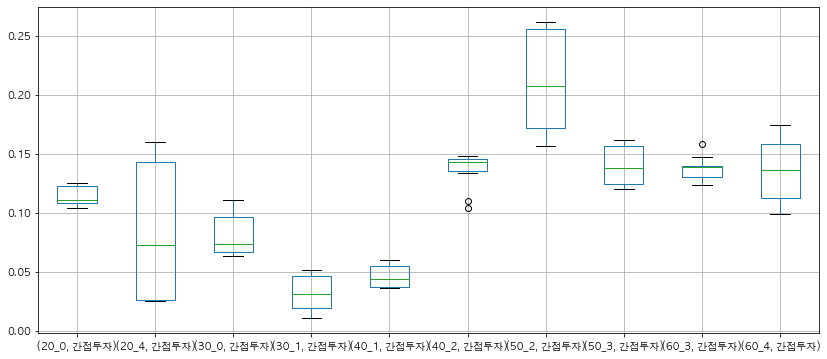

In [11]:
# 간접투자 특징 집단별 
group_data = security.groupby("그룹코드")
group_data.boxplot("그룹코드","간접투자")


<AxesSubplot:>

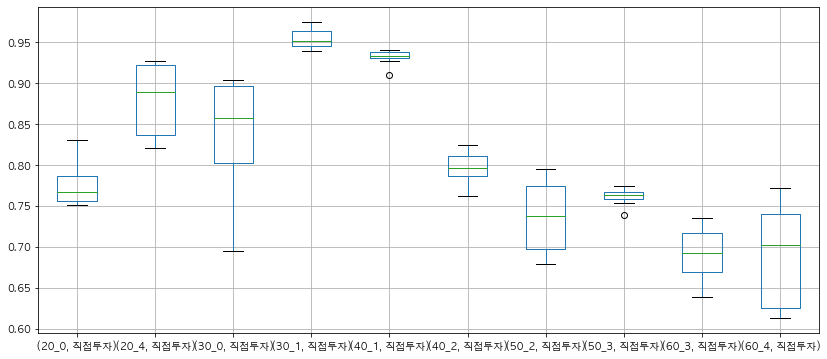

In [60]:
# 직접투자 특징 집단별
security.groupby("그룹코드").boxplot("그룹코드","직접투자")

In [19]:
security

,그룹코드,성별,기준년월,국내주식,해외주식,채권,파생결합증권,장내파생상품,단기금융상품,펀드,랩,신탁,연금,현금성자산,현물,기타,직접투자,간접투자
0,20_0,1,2021-02-01,0.530770,0.221362,0.010658,0.010309,0.0,0.000000,0.068838,0.017821,0.0,0.020627,0.119518,0.000096,0.0,0.773099,0.107286
1,20_0,1,2021-03-01,0.552040,0.222956,0.004375,0.010004,0.0,0.000000,0.081246,0.014713,0.0,0.012161,0.102342,0.000163,0.0,0.789375,0.108120
2,20_0,1,2021-11-01,0.563691,0.204540,0.026413,0.000000,0.0,0.035947,0.053261,0.022535,0.0,0.027940,0.065523,0.000149,0.0,0.830591,0.103736
3,20_0,1,2021-04-01,0.556756,0.221371,0.004768,0.006890,0.0,0.013992,0.081372,0.014182,0.0,0.013699,0.086745,0.000225,0.0,0.803777,0.109253
4,20_0,1,2021-06-01,0.557486,0.201864,0.019791,0.000000,0.0,0.000000,0.078618,0.012741,0.0,0.033593,0.095595,0.000312,0.0,0.779140,0.124952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,60_4,0,2021-12-01,0.512536,0.050519,0.108692,0.009360,0.0,0.035225,0.058672,0.014586,0.0,0.025683,0.184187,0.000541,0.0,0.716332,0.098940
96,60_4,0,2021-11-01,0.546219,0.048154,0.134439,0.005140,0.0,0.037385,0.069859,0.012031,0.0,0.029107,0.117072,0.000594,0.0,0.771337,0.110997
97,60_4,0,2021-10-01,0.538259,0.043407,0.147534,0.004419,0.0,0.036141,0.073288,0.009906,0.0,0.027022,0.119475,0.000549,0.0,0.769760,0.110216
98,60_4,0,2021-02-01,0.416700,0.029629,0.119386,0.014989,0.0,0.036205,0.076404,0.016389,0.0,0.023516,0.266783,0.000000,0.0,0.616908,0.116309


In [24]:
order_by

,그룹코드,성별,기준년월,국내주식,해외주식,채권,파생결합증권,장내파생상품,단기금융상품,펀드,랩,신탁,연금,현금성자산,현물,기타,직접투자,간접투자
92,60_4,1,2021-12-01,0.567621,0.100886,0.046736,0.005493,0.000000e+00,0.014457,0.066885,0.016134,0.049340,0.029545,0.102904,0.000000,0.0,0.735192,0.161904
95,60_4,0,2021-12-01,0.512536,0.050519,0.108692,0.009360,0.000000e+00,0.035225,0.058672,0.014586,0.000000,0.025683,0.184187,0.000541,0.0,0.716332,0.098940
90,60_4,1,2021-11-01,0.574730,0.108840,0.046438,0.007729,0.000000e+00,0.003719,0.067640,0.016537,0.050349,0.029961,0.094058,0.000000,0.0,0.741455,0.164487
96,60_4,0,2021-11-01,0.546219,0.048154,0.134439,0.005140,0.000000e+00,0.037385,0.069859,0.012031,0.000000,0.029107,0.117072,0.000594,0.0,0.771337,0.110997
91,60_4,1,2021-10-01,0.543048,0.090597,0.042472,0.006623,0.000000e+00,0.006131,0.061361,0.014869,0.045897,0.026432,0.162571,0.000000,0.0,0.688871,0.148559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,20_0,0,2021-08-01,0.620767,0.133518,0.001773,0.000000,6.682317e-07,0.000138,0.121324,0.000000,0.000000,0.003994,0.118486,0.000000,0.0,0.756196,0.125318
4,20_0,1,2021-06-01,0.557486,0.201864,0.019791,0.000000,0.000000e+00,0.000000,0.078618,0.012741,0.000000,0.033593,0.095595,0.000312,0.0,0.779140,0.124952
3,20_0,1,2021-04-01,0.556756,0.221371,0.004768,0.006890,0.000000e+00,0.013992,0.081372,0.014182,0.000000,0.013699,0.086745,0.000225,0.0,0.803777,0.109253
1,20_0,1,2021-03-01,0.552040,0.222956,0.004375,0.010004,0.000000e+00,0.000000,0.081246,0.014713,0.000000,0.012161,0.102342,0.000163,0.0,0.789375,0.108120


In [32]:
order_by = security.sort_values(["그룹코드",'기준년월'],ascending = True)
order_by = order_by[['그룹코드','기준년월','직접투자','간접투자','현금성자산','현물']]

indirect_pct_change = pd.Series()
direct_pct_change = pd.Series()
indirect_list = []
direct_list = []

for group_code in order_by['그룹코드'].unique():
    A = order_by[order_by['그룹코드']==group_code]
    A['간접투자변화율'] = A['간접투자'].pct_change()
    A['직접투자변화율'] = A['직접투자'].pct_change()
    
    indirect_list += list(A['간접투자변화율'].values)
    direct_list += list(A['직접투자변화율'].values)


indirect_pct_change = pd.Series(indirect_list)    
direct_pct_change = pd.Series(direct_list)    

order_by['직접투자변화율'] = direct_pct_change
order_by['간접투자변화율'] = indirect_pct_change

order_by

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


,그룹코드,기준년월,직접투자,간접투자,현금성자산,현물,직접투자변화율,간접투자변화율
0,20_0,2021-02-01,0.773099,0.107286,0.119518,0.000096,NaN,NaN
1,20_0,2021-03-01,0.789375,0.108120,0.102342,0.000163,0.021053,0.007772
3,20_0,2021-04-01,0.803777,0.109253,0.086745,0.000225,-0.030651,0.143697
4,20_0,2021-06-01,0.779140,0.124952,0.095595,0.000312,-0.029448,0.002929
9,20_0,2021-08-01,0.756196,0.125318,0.118486,0.000000,-0.014249,-0.006090
...,...,...,...,...,...,...,...,...
97,60_4,2021-10-01,0.769760,0.110216,0.119475,0.000549,0.040302,-0.325192
90,60_4,2021-11-01,0.741455,0.164487,0.094058,0.000000,NaN,NaN
96,60_4,2021-11-01,0.771337,0.110997,0.117072,0.000594,-0.036771,0.492401
92,60_4,2021-12-01,0.735192,0.161904,0.102904,0.000000,-0.010432,-0.334088


In [33]:
group = security.groupby("그룹코드")

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

order_by.dropna(inplace= True)
target_data = order_by[['직접투자','간접투자','직접투자변화율','간접투자변화율']]
# sc = StandardScaler()
# cc_scaled = sc.fit_transform(target_data)
# target_data = pd.DataFrame(cc_scaled,columns = ["직접투자","간접투자"])

# target_data

In [37]:
kmeans = KMeans(n_clusters = 2)
clusters = kmeans.fit(target_data)
target_data['클러스터'] = clusters.labels_
target_data

,직접투자,간접투자,직접투자변화율,간접투자변화율,클러스터
1,0.789375,0.108120,0.021053,0.007772,0
3,0.803777,0.109253,-0.030651,0.143697,0
4,0.779140,0.124952,-0.029448,0.002929,0
9,0.756196,0.125318,-0.014249,-0.006090,0
8,0.755640,0.124337,-0.082911,0.071404,0
...,...,...,...,...,...
91,0.688871,0.148559,-0.010313,0.389765,0
97,0.769760,0.110216,0.040302,-0.325192,0
96,0.771337,0.110997,-0.036771,0.492401,0
92,0.735192,0.161904,-0.010432,-0.334088,0


/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='간접투자', ylabel='직접투자'>

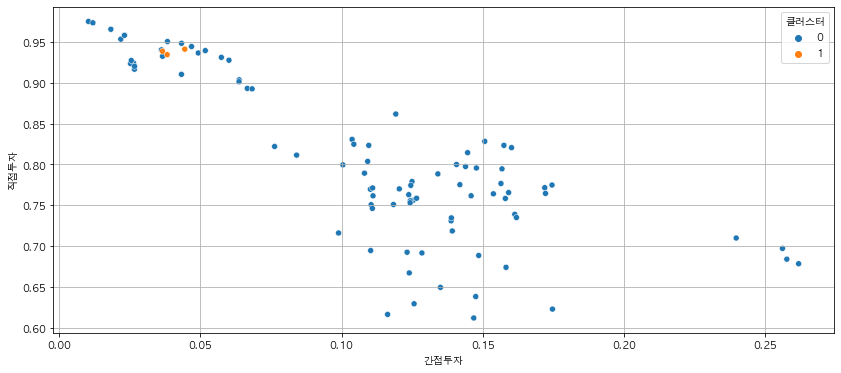

In [38]:
import seaborn as sns
sns.scatterplot("간접투자","직접투자",hue = "클러스터", data= target_data)

In [118]:
target_data.groupby(["그룹코드","클러스터"])['클러스터'].count()

그룹코드  클러스터
20_0  0       10
20_4  0        3
      1        7
30_0  0        5
      1        5
30_1  1       10
40_1  1       10
40_2  0       10
50_2  0       10
50_3  0       10
60_3  0       10
60_4  0       10
Name: 클러스터, dtype: int64

In [39]:
clusters.inertia_

6.9583692818883955

In [ ]:
clusters.